Synthesizing [adversarial examples](https://arxiv.org/abs/1312.6199) for neural networks is surprisingly easy: small, carefully-crafted perturbations to inputs can cause neural networks to misclassify inputs in arbitrarily chosen ways. Given that adversarial examples [transfer to the physical world](https://arxiv.org/abs/1607.02533) and [can be made extremely robust](https://blog.openai.com/robust-adversarial-inputs/), this is a real security concern.

In this notebook, we'll give a brief introduction to algorithms for synthesizing adversarial examples, and we'll walk through the process of implementing attacks in [TensorFlow](https://www.tensorflow.org/), building up to synthesizing a robust adversarial example following [this technique](https://arxiv.org/abs/1707.07397).

# Setup

We'll attack an [Inception v3](https://arxiv.org/abs/1512.00567) network trained on [ImageNet](http://www.image-net.org/). In this section, we load a pre-trained network from the [TF-slim image classification library](https://github.com/tensorflow/models/tree/master/slim). This part isn't particularly interesting, so feel free to skip reading this section.

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

First, we set up the input image.

In [3]:
x = tf.placeholder(tf.float32, (299, 299, 3)) # InceptionV3 takes a 299x299x3 input

Next, we load the Inception v3 model.

In [4]:
def inception(x, reuse):
    preprocessed = tf.multiply(tf.subtract(x, 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(tf.expand_dims(x, 0), reuse=False)
# gives us logits (pre-softmax) and probabilities (post-softmax)

Next, we load pre-trained weights. This Inception v3 has a top-5 accuracy of 93.9%.

In [5]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [6]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [7]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

Next, we write some code to show an image, classify it, and show the classification result.

In [8]:
import json
import matplotlib.pyplot as plt

In [9]:
with open('resources/imagenet.json') as f:
    imagenet_labels = json.load(f)

In [10]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={x: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example image

We load our example image and make sure it's classified correctly.

In [11]:
import PIL.Image
import numpy as np

In [12]:
img_class = 281
img = PIL.Image.open('resources/cat.jpg')
# take a square center crop of the image and convert it to a float32 image with pixels in [0, 1]
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

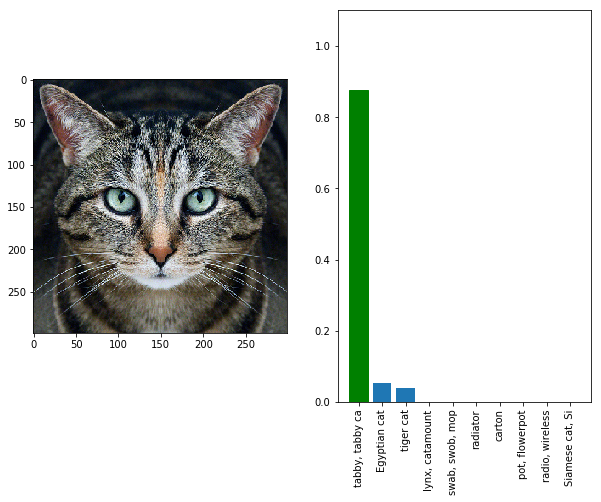

In [13]:
classify(img, correct_class=img_class)

As we expect, it's classified as a cat.

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ box with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using backpropagation and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

## Setup

In [14]:
y_hat = tf.placeholder(tf.int32, ()) # a placeholder for the target class
labels = tf.one_hot(y_hat, 1000) # InceptionV3 uses one-hot encoded labels
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])

## Parameters

Before we perform our attack, let's choose some concrete parameters.

In [15]:
epsilon = 2.0/255.0 # a really small perturbation
target = 924 # this is "guacamole"; you could try choosing anything else

## Projected gradient descent

We use projected gradient descent to maximize the log probability of the target class (or equivalently, minimize the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)) while keeping the adversarial example visually close to the original image (what happens if we don't do this?).

In [16]:
grad, = tf.gradients(loss, x)

We can evaluate the gradient `grad` at a particular $x = $ `x_hat` and $\hat{y}$ = `target` by running `grad.eval({x: x_hat, y_hat: target})`.

Finally, we're ready to run projected gradient descent to find our adversarial example `x_hat`.

In [17]:
learning_rate = 1e-1
iterations = 30

x_hat = np.copy(img) # initial guess

upper = np.clip(img + epsilon, 0, 1) # an upper bound for pixels in the image
lower = np.clip(img - epsilon, 0, 1) # a lower bound for pixels in the image

for i in range(iterations):
    # gradient descent step
    x_hat = x_hat - learning_rate * grad.eval({x: x_hat, y_hat: target})
    
    # projection step; what happens if you don't do this (and e.g. clip to [0, 1] instead)?
    x_hat = np.clip(x_hat, lower, upper)
    
    # print progress
    l = loss.eval({x: x_hat, y_hat: target})
    print('step %d, loss %f' % (i, l))

step 0, loss 7.755202
step 1, loss 6.753644
step 2, loss 6.180379
step 3, loss 5.747485
step 4, loss 5.330523
step 5, loss 4.991937
step 6, loss 4.734199
step 7, loss 4.431602
step 8, loss 4.119524
step 9, loss 3.866385
step 10, loss 3.494417
step 11, loss 3.183333
step 12, loss 2.812327
step 13, loss 2.406202
step 14, loss 2.106692
step 15, loss 1.902959
step 16, loss 1.625870
step 17, loss 0.970312
step 18, loss 0.505992
step 19, loss 0.929034
step 20, loss 0.312043
step 21, loss 0.216778
step 22, loss 0.116401
step 23, loss 0.079910
step 24, loss 0.056526
step 25, loss 0.048945
step 26, loss 0.044176
step 27, loss 0.040627
step 28, loss 0.037977
step 29, loss 0.035877


This adversarial image is visually indistinguishable from the original, with no visual artifacts. However, it's classified as "guacamole" with high confidence!

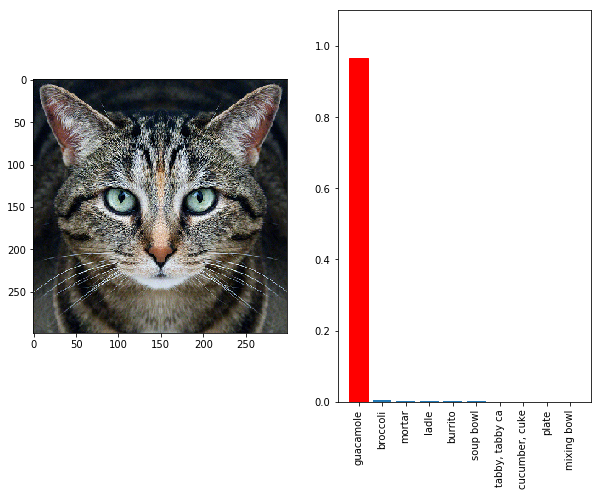

In [18]:
classify(x_hat, correct_class=img_class, target_class=target)

# Robust adversarial examples

Now, we go through a more advanced example. We follow an approach for synthesizing robust adversarial examples to find a single perturbation of our cat image that's simultaneously adversarial under some chosen distribution of transformations.  We could choose any distribution of differentiable transformations; in this post, we'll synthesize a single adversarial input that's robust to rotation by $\theta \in [-\pi/4, \pi/4]$.

Before we proceed, let's check if our previous example is still adversarial if we rotate it, say by an angle of $\theta = \pi/8$.

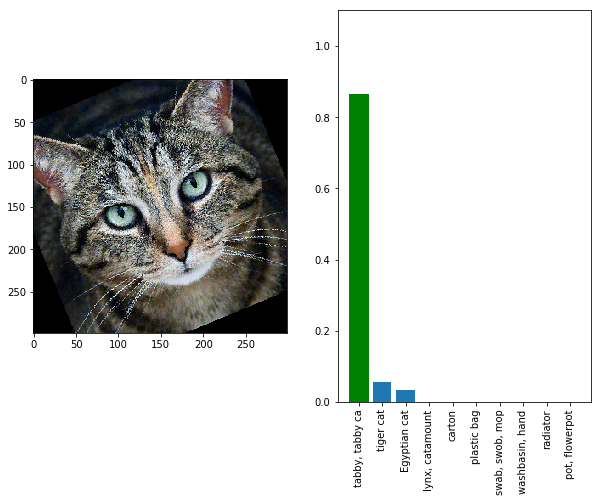

In [19]:
ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(x, angle)
rotated_example = rotated_image.eval(feed_dict={x: x_hat, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=target)

Looks like our original adversarial example is not rotation-invariant!

So, how do we make an adversarial example robust to a distribution of transformations? Given some distribution of transformations $T$, we can maximize $\mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$, subject to $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$. We can solve this optimization problem via projected gradient descent, noting that $\nabla \mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ is $\mathbb{E}_{t \sim T} \nabla \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ and approximating with samples at each gradient descent step.

Rather than manually implementing the gradient sampling, we can get TensorFlow to do it for us.

In [20]:
num_samples = 10 # samples per step

rotated = []
for i in range(num_samples):
    rotated.append(tf.contrib.image.rotate(
        x, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4)))
rotated = tf.stack(rotated)
rotated_logits, _ = inception(rotated, reuse=True)

duplicated_labels = tf.tile(tf.expand_dims(labels, 0), (num_samples, 1))

average_loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=rotated_logits, labels=duplicated_labels))

## Projected gradient descent

Now, we can run PGD just like we did last time to generate our adversarial input. As in the previous example, we'll choose "guacamole" as our target class.

In [21]:
grad_robust, = tf.gradients(average_loss, x)

In [22]:
epsilon = 8.0/255.0 # still a pretty small perturbation
learning_rate = 2e-1
iterations = 50

x_hat_robust = np.copy(img) # initial guess

upper = np.clip(img + epsilon, 0, 1) # an upper bound for pixels in the image
lower = np.clip(img - epsilon, 0, 1) # a lower bound for pixels in the image

for i in range(iterations):
    # gradient descent step
    x_hat_robust = x_hat_robust - learning_rate * grad_robust.eval({x: x_hat_robust, y_hat: target})
    
    # projection step; what happens if you don't do this (and e.g. clip to [0, 1] instead)?
    x_hat_robust = np.clip(x_hat_robust, lower, upper)
    
    # print progress
    l = average_loss.eval({x: x_hat_robust, y_hat: target})
    print('step %d, average loss %f' % (i, l))

step 0, average loss 9.038750
step 1, average loss 8.684229
step 2, average loss 8.396453
step 3, average loss 8.302599
step 4, average loss 8.063894
step 5, average loss 7.726541
step 6, average loss 7.760277
step 7, average loss 7.546046
step 8, average loss 7.353661
step 9, average loss 7.564486
step 10, average loss 6.974760
step 11, average loss 6.921107
step 12, average loss 6.763664
step 13, average loss 6.880454
step 14, average loss 6.727576
step 15, average loss 6.543626
step 16, average loss 6.514064
step 17, average loss 6.365477
step 18, average loss 6.192029
step 19, average loss 6.246026
step 20, average loss 6.121813
step 21, average loss 6.023622
step 22, average loss 5.830117
step 23, average loss 5.778733
step 24, average loss 5.859807
step 25, average loss 5.464859
step 26, average loss 5.234110
step 27, average loss 5.516845
step 28, average loss 4.938727
step 29, average loss 5.150127
step 30, average loss 4.784441
step 31, average loss 4.804159
step 32, average l

This adversarial image is classified as "guacamole" with high confidence, even when it's rotated!

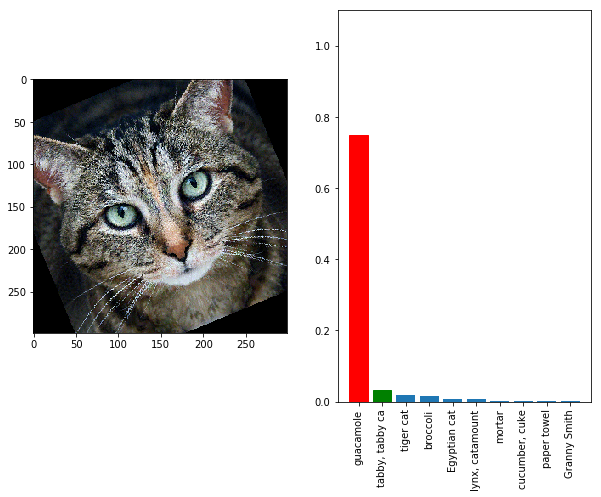

In [23]:
rotated_example = rotated_image.eval(feed_dict={x: x_hat_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=target)

## Evaluation

Let's examine the rotation-invariance of the robust adversarial example we produced over the entire range of angles, looking at $P(\hat{y} \mid \hat{\mathbf{x}})$ over $\theta \in [-\pi/4, \pi/4]$.

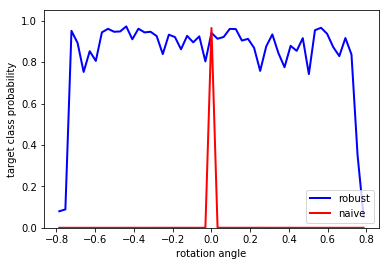

In [24]:
thetas = np.linspace(-np.pi/4, np.pi/4, 51)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={x: x_hat_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={x: rotated})[0][target])
    
    rotated = rotated_image.eval(feed_dict={x: x_hat, angle: theta})
    p_naive.append(probs.eval(feed_dict={x: rotated})[0][target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()

It's super effective!

# More exploration

Finished early? Try making this work for other types of transformation, such as random crops, rescaling, or shearing.